In [13]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import *
import math
import re
import os
import seaborn as sbn
sbn.set_style("whitegrid")

import matplotlib.image as mpimg
from matplotlib.mlab import griddata
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [14]:
def mean_std(ifile):
    
    #for each bond length compute the mean 
    #and the std
    counter = 0 
    count_elems = 0 # this is the counter elements
    end = len(ifile)
    distances = []
    results = {}
    
    for val in ifile:
        bondlength = val[0]
        distance = val[2]
        
        if counter==0:
            #a the first time, define a tmp value
            tmp = bondlength
            counter+=1
        
        if tmp!=bondlength:
            #in this case we've finished with the distance i-th
            #we are starting i-th +1
            #compute the mean value
            mean = np.mean(distances)
            std = np.std(distances)
            stderr = std/math.sqrt(len(distances))
            results[tmp] = [ mean,std,stderr]
            #empty the distances
            distances = []
            #update the tmp val
            tmp = bondlength
            distances.append(distance)
        
        if count_elems == end-1:
            #this is the last bondlength value
            mean = np.mean(distances)
            std = np.std(distances)
            stderr = std/math.sqrt(len(distances))
            results[tmp]= [mean,std,stderr]
            
        
        distances.append(distance)
        count_elems+=1
    
    return results

In [15]:
def compute_N(r):
    #Given an agreement distance we map this distance onto a spherical surface
    #then we compute how many particles with radius = 2.0 A are present on the surface
    #such particles are  like water molecules, whose radius is 2.0 A
    #to simplify the calculation just compute r**2/4
    N = (r**2)/(4.0)
    return N

In [18]:
ifile = loadtxt("theta_dist.csv",delimiter=",",usecols=[0,1,2])
#first column ifile[:,0] , second ifile[:,1], third ifile[:,2]

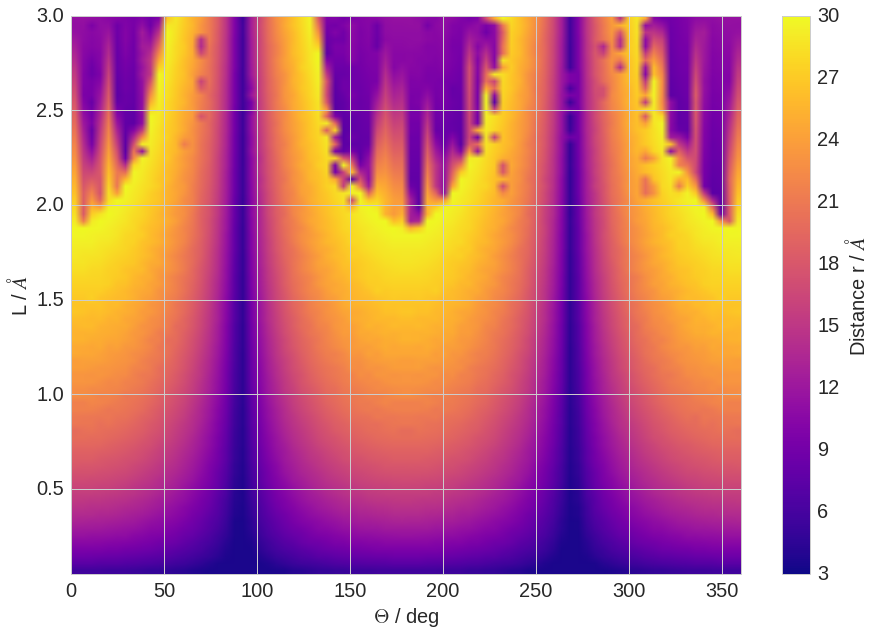

In [55]:
#Heat map

bondlength = []
theta = []
distance = [] #distance where the two curves perfectly match

for vals in ifile:
    #angle = vals[1]
    #if (angle<95 and angle>85) or (angle<275 and angle>265):
    #    continue
    #else:
    bondlength.append(vals[0])
    theta.append(vals[1])
    distance.append(vals[2])
    
    
theta = asarray(theta)
bondlength = asarray(bondlength)
distance = asarray(distance)
#now create the meshgrid
xi,yi = linspace(theta.min(),theta.max(),80) , linspace(bondlength.min(),bondlength.max(),80)
xi,yi = meshgrid(xi,yi)
#interpolate
zi = interpolate.griddata((theta,bondlength),distance,(xi,yi),method="linear")

fig,ax = plt.subplots(figsize=(15,10))
cmap="plasma"
cax = ax.imshow(zi, vmin=distance.min(), vmax=distance.max(), origin='lower',
           extent=[theta.min(), theta.max(), bondlength.min(), bondlength.max()],aspect="auto",\
          cmap=cmap )

ax.set_xlabel("$\Theta$ / deg",fontsize=20)
ax.set_ylabel(r"L / $\AA$",fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ticks = np.linspace(3.0,30.0,10.0)
cbar = fig.colorbar(cax, ticks=ticks)

#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
#cbar.set_clim(1.0, 16.0)
cbar.ax.set_ylabel(r"Distance r / $\AA$",fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.savefig("HeatMap_distance.png",dpi=300)


In [21]:
mean_dict = mean_std(ifile)

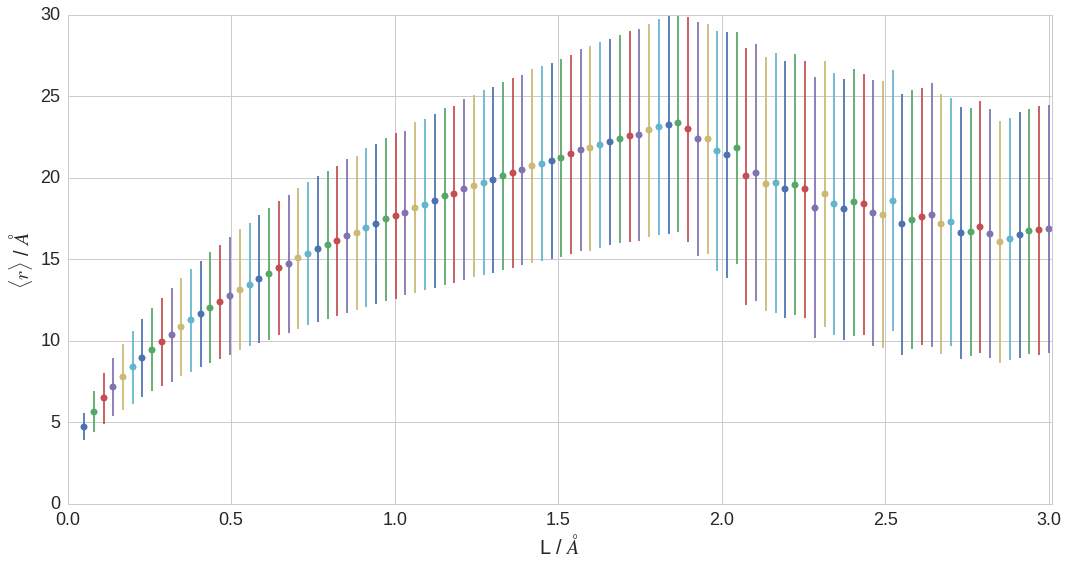

In [47]:
#plot
color = sbn.color_palette(n_colors=101)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
#we need to sort out the keys
keys = []
for key in mean_dict.keys():
    keys.append(key)

keys.sort()

counter=0
for key in keys:
    
    ax.errorbar(key,mean_dict[key][0],color=color[counter],yerr=mean_dict[key][1],marker="o")
    counter+=1

ax.set_xlabel("L / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\langle r\rangle$ / $\AA$" ,fontsize=20) 
ax.set_ylim(0,30)
ax.set_xlim(0,3.01)
plt.tight_layout()

plt.savefig("Mean_std_distance.png",dpi=300)

In [52]:
#now for all these values, take the average distance
#compute the number  N of particles /water on the spherical surface for this distance
#thus compute the RF charge-dipole rotationally averaged interaction by N
#multiply the associate error of r by N
#

spherical_distance = {}
for key in keys:
    #compute the  number of particles 
    r = mean_dict[key][0]
    N = compute_N(r)
    #multiply the error
    newr  = N*r
    stddev = mean_dict[key][2]
    Nstddev = N*stddev
    #now for each error we have we need to compute the value of r
    spherical_distance[key]  = [ newr, Nstddev]

    


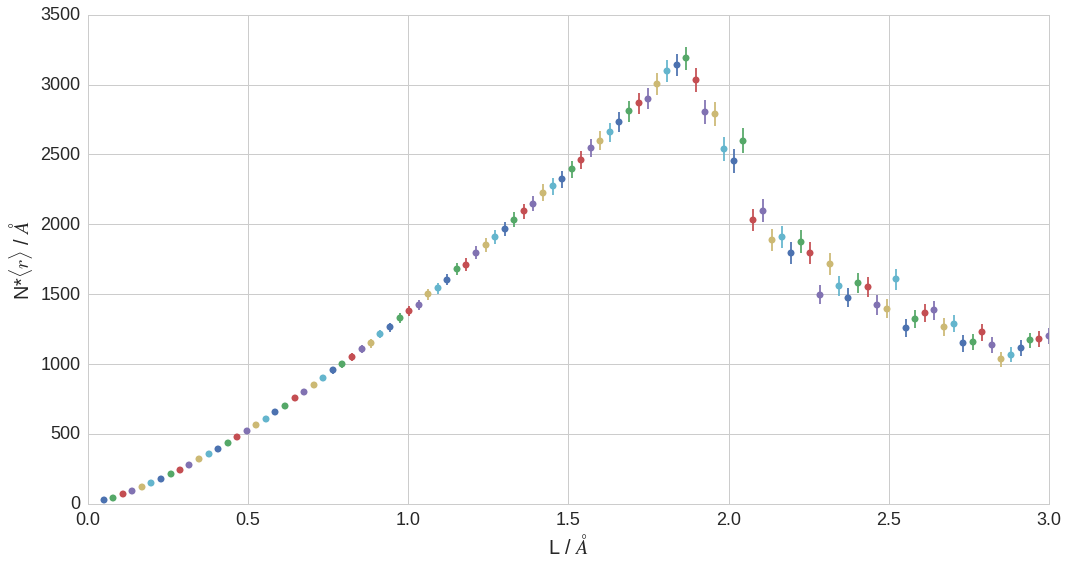

In [54]:
#plot
color = sbn.color_palette(n_colors=101)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
#we need to sort out the keys
keys = []
for key in mean_dict.keys():
    keys.append(key)

keys.sort()

counter=0
for key in keys:
    
    ax.errorbar(key,spherical_distance[key][0],color=color[counter],yerr=spherical_distance[key][1],marker="o")
    counter+=1

ax.set_xlabel("L / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"N*$\langle r\rangle$ / $\AA$" ,fontsize=20) 
#ax.set_ylim(0,60)
#ax.set_xlim(0,0.5)
plt.tight_layout()

#plt.savefig("Mean_std_distance.png",dpi=300)